In [3]:
import numpy as np
import pandas as pd
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.float_format","{:.5f}".format)

In [4]:
df=pd.read_csv("heart.csv")
#https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [5]:
df.shape,df.columns

((918, 12),
 Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
        'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
        'HeartDisease'],
       dtype='object'))

In [6]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The dataset is clean
# Exploratory data analysis

<Axes: xlabel='Age', ylabel='Count'>

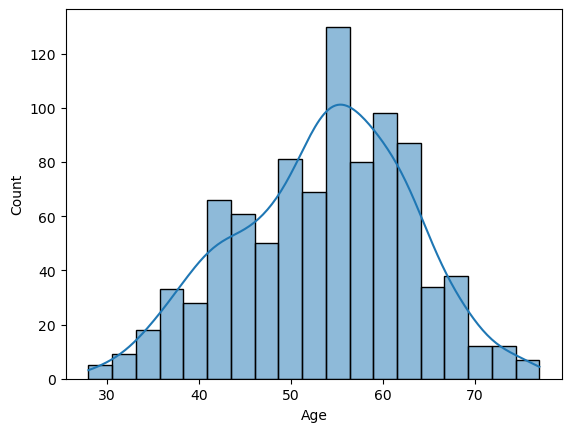

In [7]:
import seaborn as sns
sns.histplot(df["Age"],kde=True)

Sex
F   0.25907
M   0.63172
Name: HeartDisease, dtype: float64


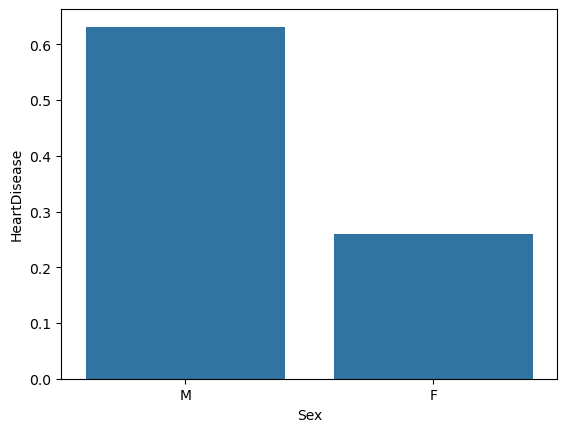

In [8]:
sns.barplot(x=df["Sex"],y=df["HeartDisease"],ci=None)
print(df.groupby("Sex")["HeartDisease"].mean())

Men have a higgher chance of having a heart disease

In [9]:
df.groupby("ChestPainType")["HeartDisease"].mean()

ChestPainType
ASY   0.79032
ATA   0.13873
NAP   0.35468
TA    0.43478
Name: HeartDisease, dtype: float64

Most patients that had a heart disease were asymptomatic (this is due to the fact that asymptomatic patients are not likely to go to the hospital or doctor) followed by patients that had typical angina (TA)

# Data preparation

In [10]:
from pandas.api.types import is_numeric_dtype
X_numericals=pd.DataFrame()
X_dummies=pd.DataFrame()

for column in df.columns:
        #make 2 datafraμes, one for numerical and one for categorical variables
        #categorical variables will be converted to dummies
        if df[column].dtype == 'object':
            dummies = pd.get_dummies(df[column], prefix=column, drop_first=False)
            X_dummies = pd.concat([X_dummies, dummies], axis=1)
        elif is_numeric_dtype(df[column]):
            X_numericals = pd.concat([X_numericals, df[[column]]], axis=1)
            numerical_names=X_numericals.columns
    

In [11]:
from sklearn.preprocessing import StandardScaler
X_numericals=StandardScaler().fit_transform(X_numericals)

In [15]:
X_numericals=pd.DataFrame(X_numericals,columns=numerical_names)
X=pd.concat([X_numericals,X_dummies],axis=1)
X=X.drop("HeartDisease",axis=1)
y=df["HeartDisease"]

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)

In [18]:
param_dist={
    #define parameter distirbution for RandomizedSearchCV
    "max_depth":[3,5,7,9,11,13,15], #Set the maximum depth of the tree
    "min_samples_split":[2,3,4,5,6],# Set the minimum number of samples required to split an internal node
    "min_samples_leaf":[1,2,3,4,5,7,9,10], # Set the minimum number of samples required to be at a leaf node
    "criterion":["gini","entropy"]  # Set the function to measure the quality of a split
}

In [34]:
random_search=RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_dist,
    n_iter=200,
    scoring="recall",
    cv=5,)

The target variable is balanced. We will focus on recall since we want to minimize false negatives (predicting that a patient is healthy when he is not)

In [35]:
random_search.fit(X_train,y_train)
random_search.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 5,
 'criterion': 'entropy'}

In [36]:
y_pred=random_search.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Recall",recall_score(y_test,y_pred))
print("ROC AUC Score:",roc_auc_score(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))

Accuracy: 0.8521739130434782
Recall 0.8794326241134752
ROC AUC Score: 0.8442106940792095
Confusion Matrix: [[ 72  17]
 [ 17 124]]


In [37]:
#Get feature importances
importances=random_search.best_estimator_.feature_importances_
feature_names=X.columns
feature_importances=pd.DataFrame({"Feature":feature_names,"Importance":importances}) 

In [38]:
feature_importances.sort_values(by="Importance",ascending=False)

,Feature,Importance
19,ST_Slope_Up,0.44979
8,ChestPainType_ASY,0.13327
4,MaxHR,0.10906
5,Oldpeak,0.10137
2,Cholesterol,0.06767
7,Sex_M,0.03739
0,Age,0.03704
15,ExerciseAngina_N,0.02127
10,ChestPainType_NAP,0.01906
3,FastingBS,0.01427


# SVM

In [39]:
from sklearn.svm import SVC

In [40]:
param_dist={ #SCV parameters
    "C":np.arange(0.1,100,10), 
    "kernel":["linear","rbf","poly"], 
    "gamma":["scale","auto"] 

}

In [41]:
random_search = RandomizedSearchCV(
    SVC(),
    param_distributions=param_dist,
    n_iter=50,
    scoring="recall",
    cv=5
    )

In [42]:
random_search=random_search.fit(X_train,y_train)
random_search.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}

In [43]:
best_model=random_search.best_estimator_
y_pred=best_model.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Recall",recall_score(y_test,y_pred))
print("ROC AUC Score:",roc_auc_score(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))

Accuracy: 0.8869565217391304
Recall 0.900709219858156
ROC AUC Score: 0.8829388795919995
Confusion Matrix: [[ 77  12]
 [ 14 127]]


In [44]:
#Feature importances
from sklearn.inspection import permutation_importance
result = permutation_importance(best_model, X_train, y_train, n_repeats=100, random_state=1)
importances=result.importances_mean
feature_names=X.columns
feature_importances=pd.DataFrame({"Feature":feature_names,"Importance":importances})
feature_importances.sort_values(by="Importance",ascending=False)

,Feature,Importance
5,Oldpeak,0.02859
2,Cholesterol,0.02503
18,ST_Slope_Flat,0.01640
19,ST_Slope_Up,0.01581
8,ChestPainType_ASY,0.00686
3,FastingBS,0.00670
1,RestingBP,0.00616
6,Sex_F,0.00452
7,Sex_M,0.00452
0,Age,0.00390


# Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
param_dist={ #Logistic Regression parameters
    "C":np.arange(0.1,100,10), 
    "penalty":["l1","l2","elasticnet","none"], 
    "solver":["newton-cg","lbfgs","liblinear","sag","saga"],
    "max_iter":[100,200,300,400,500]
}

In [47]:
random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=100,
    scoring="recall",
    cv=5
)   

In [48]:
random_search.fit(X_train,y_train)
random_search.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 0.1}

In [49]:
best_model=random_search.best_estimator_
y_pred=best_model.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Recall",recall_score(y_test,y_pred))
print("ROC AUC Score:",roc_auc_score(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))

Accuracy: 0.8869565217391304
Recall 0.8865248226950354
ROC AUC Score: 0.8870826360666187
Confusion Matrix: [[ 79  10]
 [ 16 125]]


# Neural Network

In [50]:
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam      #import adam optimizer

In [51]:
model = Sequential([
    Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [52]:
model.compile(optimizer=Adam(learning_rate=0.001),
     loss='binary_crossentropy',
    metrics=['recall'])
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.1)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6816 - recall: 0.9929 - val_loss: 0.5664 - val_recall: 0.9459
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4931 - recall: 0.9193 - val_loss: 0.4737 - val_recall: 0.8919
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3990 - recall: 0.8637 - val_loss: 0.4438 - val_recall: 0.8919
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3530 - recall: 0.8900 - val_loss: 0.4397 - val_recall: 0.8919
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3710 - recall: 0.8577 - val_loss: 0.4464 - val_recall: 0.9189
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3410 - recall: 0.8887 - val_loss: 0.4450 - val_recall: 0.9189
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2998 - recall: 0.8968 - val_loss: 0.4393 - val_recall: 0.9189
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2916 - recall: 0.9062 - val_loss: 0.4376 - val_recall: 0.9189
Epoch 9/20
78/78 ━━━━━━━

In [53]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        89
           1       0.91      0.90      0.91       141

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



The desicion Tree and the neural network classifier give us the best recall at 90%